# Word Count Analysis

In [1]:
#import libraries
import pandas as pd
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import altair as alt
import math

In [2]:
#import dataframes
df_cty = pd.read_csv('df_cty_final.csv',converters={'words':eval})
df_rb = pd.read_csv('df_rb_final.csv',converters={'words':eval})
df_rock = pd.read_csv('df_rock_final.csv',converters={'words':eval})

### Functions

In [3]:
def remove_num(text):
    '''
    function returns text with numbers removed
    parameter:
        text-->str
    '''
    for word in text:
        try:
            int(word)
            text.remove(word)
        except:
            pass
    return text

In [4]:
def word_count(word_list):
    '''
    function returns dataframe with word count information
    parameter:
        word_list-->list of word lists for each song in dataframe
    '''
    word_counts = Counter() #number of times a word appears in all songs
    
    for l in word_list:
        word_counts.update(l) #update word counts
    
    #create new dataframe
    df = pd.DataFrame(data={'word':word_counts.keys(),
                            'count':word_counts.values()})
    df['count_pct'] = df['count'].apply(lambda x: x/df['count'].sum()) #percent total (based on total word count)
    
    return df.sort_values(by='count',ascending=False).reset_index(drop=True)

In [5]:
def calc_tf_idf(song_list):
    '''
    function returns dataframe with tf-idf values for song list
    parameter:
        song_list-->list of lists of words in each song
            *['words'] column in genre dataframe
    '''
    #initiate variables
    corpus = set([word for song in song_list for word in song]) #set of all words in dataframe
    tf_list = [] #variable to hold dict of word counts for each song (for TF)
    total_appear = Counter() #counts for # of docs in which word appears (for IDF)
    N = len(song_list) #number of docs (for IDF)
    tf_idf_list = [] #variable to hold combined TF-IDF values
    
    #CALCULATE TERM FREQUENCY
    for song in song_list: #create dict with tf for each song
        total_appear.update(set(song)) #update for IDF analysis (below)
        d = dict.fromkeys(corpus,0)
        for word in song:
            d[word]+=1 #update word count
        d = {k:v/len(song) for k,v in d.items()} #normalize word counts
        tf_list.append(d) #add dictionary to dict_list
    
    #CALCULATE INVERSE DOCUMENT FREQUENCY
    total_appear = {k:total_appear[k] for k in corpus} #reorder dict to align with corpus
    idf = {k:math.log10(N/(v+1)) for k,v in total_appear.items()}
    
    #COMBINE
    for song in tf_list:
        tf_idf_dict = {k:v*idf[k] for k,v in song.items()}
        tf_idf_list.append(tf_idf_dict)
        
    #create dataframe with tf-idf values
    df=pd.DataFrame(tf_idf_list)
    
    return df.reset_index(drop=True)

In [6]:
def word_freq_df(df):
    """
    function returns sorted dataframe with word frequencies
    parameter:
        df-->dataframe with tf-idf values
    """
    new_df = pd.DataFrame({'weight':df.sum()})
    return new_df.sort_values(by='weight',ascending=False).reset_index().rename(columns={'index':'word'})

### Create Dataframes with Word Counts

In [7]:
#remove numbers from dataframes
df_cty['words'] = df_cty['words'].apply(remove_num) #country
df_rb['words'] = df_rb['words'].apply(remove_num) #R&B/hip-hop
df_rock['words'] = df_rock['words'].apply(remove_num) #rock/alternative

In [8]:
#word count dataframes
df_cty_word = word_count(df_cty['words']) #country
df_rb_word = word_count(df_rb['words']) #R&B/hip-hop
df_rock_word = word_count(df_rock['words']) #rock/alternative

In [9]:
df_rb_word.loc[10,'word']='n-word' #replace racial slur

In [10]:
#preview country df
df_cty_word.head()

,word,count,count_pct
0,like,3485,0.011275
1,know,2785,0.009011
2,yeah,2538,0.008212
3,love,2331,0.007542
4,one,2194,0.007099


In [11]:
#preview R&B/hip-hop df
df_rb_word.head()

,word,count,count_pct
0,yeah,5268,0.013826
1,like,4881,0.012811
2,know,3549,0.009315
3,got,3183,0.008354
4,oh,2965,0.007782


In [12]:
#preview rock/alternative df
df_rock_word.head()

,word,count,count_pct
0,like,3877,0.017342
1,yeah,3696,0.016532
2,know,2914,0.013034
3,oh,2876,0.012864
4,love,2493,0.011151


In [13]:
#write to file
df_cty_word.to_csv('df_cty_word_counts.csv') #country
df_rb_word.to_csv('df_rb_word_counts.csv') #R&B/hip-hop
df_rock_word.to_csv('df_rock_word_counts.csv') #rock/alternative

### Create Dataframes with Word Frequencies (TF-IDF)

In [14]:
#calculate tf-idf values
df_cty_tf = calc_tf_idf(df_cty['words']) #country
df_rb_tf = calc_tf_idf(df_rb['words']) #R&B/hip-hop
df_rock_tf = calc_tf_idf(df_rock['words']) #rock/alternative

In [15]:
#word frequency dataframes
df_cty_freq = word_freq_df(df_cty_tf) #country
df_rb_freq = word_freq_df(df_rb_tf) #R&B/hip-hop
df_rock_freq = word_freq_df(df_rock_tf) #rock/alternative

In [16]:
df_rb_freq.loc[3,'word']='n-word' #replace racial slur

In [17]:
#preview country df
df_cty_freq.head()

,word,weight
0,oh,3.936094
1,love,3.922907
2,wanna,3.809024
3,gonna,3.766205
4,yeah,3.354699


In [18]:
#preview R&B/hip-hop df
df_rb_freq.head()

,word,weight
0,oh,4.546665
1,yeah,4.119597
2,love,3.907749
3,n-word,3.202604
4,girl,2.992506


In [19]:
#preview rock/alternative df
df_rock_freq.head()

,word,weight
0,oh,5.475074
1,la,4.786138
2,yeah,4.666663
3,love,4.442566
4,want,3.610171


In [20]:
#write to file
df_cty_freq.to_csv('df_cty_tfidf_values.csv') #country
df_rb_freq.to_csv('df_rb_tfidf_values.csv') #R&B/hip-hop
df_rock_freq.to_csv('df_rock_tfidf_values.csv') #rock/alternative

### Generate Word Clouds Using TF-IDF Values

In [21]:
#initialize word cloud generator
wc = WordCloud(max_words=100,background_color='white')

#### Country

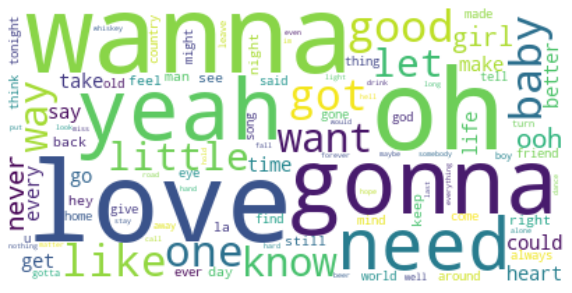

In [22]:
cty_cloud_data = dict(zip(df_cty_freq['word'].tolist(), df_cty_freq['weight'].tolist())) #dict to generate word cloud

plt.figure(figsize=(10,8))
plt.imshow(wc.generate_from_frequencies(cty_cloud_data),interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('cty_word_cloud.png') #save to file
plt.close()

#### R&B/Hip-Hop

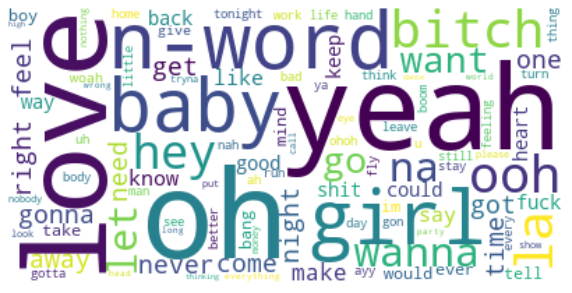

In [23]:
rb_cloud_data = dict(zip(df_rb_freq['word'].tolist(), df_rb_freq['weight'].tolist())) #dict to generate word cloud

plt.figure(figsize=(10,8))
plt.imshow(wc.generate_from_frequencies(rb_cloud_data),interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('rb_word_cloud.png') #save to file
plt.close()

#### Rock/Alternative

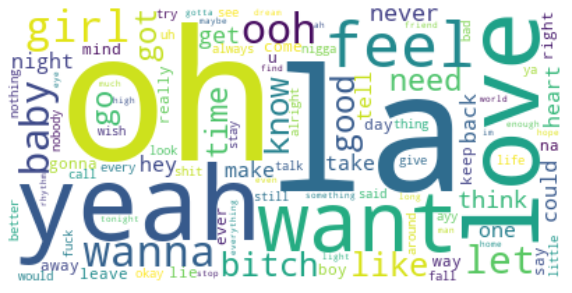

In [24]:
rock_cloud_data = dict(zip(df_rock_freq['word'].tolist(), df_rock_freq['weight'].tolist())) #dict to generate word cloud

plt.figure(figsize=(10,8))
plt.imshow(wc.generate_from_frequencies(rock_cloud_data),interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('rock_word_cloud.png') #save to file
plt.close()

### Generate Bar Charts of Top 20 Words per Genre

In [25]:
#set theme for Altair viz
alt.themes.enable('fivethirtyeight')

ThemeRegistry.enable('fivethirtyeight')

#### Country

In [55]:
#chart using word counts
cty_count_bar = alt.Chart(df_cty_word.iloc[0:20]).mark_bar(color='#ed713a').encode(
    x=alt.X('word',sort=None),
    y=alt.Y('count',axis=alt.Axis(labels=False,ticks=False,
                                  grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in country songs', 
                    'subtitle': 'Based on word counts',
                    'subtitleFontSize':15},
             width=300,
             height=300)

#sort words in tfidf chart based on order in word counts chart
d = {v:i for i,v in enumerate(df_cty_word['word'])}
x = list(df_cty_freq.iloc[0:20]['word'])
r = sorted(x, key=lambda v: d[v])

#chart using TF-IDF values
cty_tfidf_bar = alt.Chart(df_cty_freq.iloc[0:20]).mark_bar().encode(
    x=alt.X('word',sort=r),
    y=alt.Y('weight',axis=alt.Axis(labels=False,ticks=False,
                                   grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in country songs', 
                    'subtitle': 'Based on TF-IDF values',
                    'subtitleFontSize':15},
             width=300,
             height=300)

cty_bar_charts = cty_count_bar | cty_tfidf_bar

In [56]:
cty_bar_charts

ValueError: No enabled saver found that supports format='png'

alt.HConcatChart(...)

#### R&B/Hip-Hop

In [50]:
#chart using word counts
rb_count_bar = alt.Chart(df_rb_word.iloc[0:20]).mark_bar(color='#ed713a').encode(
    x=alt.X('word',sort=None),
    y=alt.Y('count',axis=alt.Axis(labels=False,ticks=False,
                                  grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in R&B/hip-hop songs', 
                    'subtitle': 'Based on word counts',
                    'subtitleFontSize':15},
             width=300,
             height=300)

#sort words in tfidf chart based on order in word counts chart
d = {v:i for i,v in enumerate(df_rb_word['word'])}
x = list(df_rb_freq.iloc[0:20]['word'])
r = sorted(x, key=lambda v: d[v])

#chart using TF-IDF values
rb_tfidf_bar = alt.Chart(df_rb_freq.iloc[0:20]).mark_bar().encode(
    x=alt.X('word',sort=r),
    y=alt.Y('weight',axis=alt.Axis(labels=False,ticks=False,
                                   grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in R&B/hip-hop songs', 
                    'subtitle': 'Based on TF-IDF values',
                    'subtitleFontSize':15},
             width=300,
             height=300)

rb_bar_charts = rb_count_bar | rb_tfidf_bar

In [51]:
rb_bar_charts

ValueError: No enabled saver found that supports format='png'

alt.HConcatChart(...)

In [ ]:
rb_bar_charts.save('rb_word_counts.png') #save to file

#### Rock/Alternative

In [52]:
#chart using word counts
rock_count_bar = alt.Chart(df_rock_word.iloc[0:20]).mark_bar(color='#ed713a').encode(
    x=alt.X('word',sort=None),
    y=alt.Y('count',axis=alt.Axis(labels=False,ticks=False,
                                  grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in rock/alternative songs', 
                    'subtitle': 'Based on word counts',
                    'subtitleFontSize':15},
             width=300,
             height=300)

#sort words in tfidf chart based on order in word counts chart
d = {v:i for i,v in enumerate(df_rock_word['word'])}
x = list(df_rock_freq.iloc[0:20]['word'])
r = sorted(x, key=lambda v: d[v])

#chart using TF-IDF values
rock_tfidf_bar = alt.Chart(df_rock_freq.iloc[0:20]).mark_bar().encode(
    x=alt.X('word',sort=r),
    y=alt.Y('weight',axis=alt.Axis(labels=False,ticks=False,
                                   grid=False,title='frequency in songs'))
).properties(title={'text': 'Top 20 words in rock/alternative songs', 
                    'subtitle': 'Based on TF-IDF values',
                    'subtitleFontSize':15},
             width=300,
             height=300)

rock_bar_charts = rock_count_bar | rock_tfidf_bar

In [53]:
rock_bar_charts

ValueError: No enabled saver found that supports format='png'

alt.HConcatChart(...)

In [ ]:
rock_bar_charts.save('rock_word_counts.png') #save to file